#1. 이해하기

## 1.1 LoopAgent

### 1.1.1 역할 및 특징

1.  반복적 실행: LoopAgent의 주요 기능은 지정된 하위 에이전트 목록을 **반복적으로 실행**하는 것입니다. 각 반복 주기(iteration) 내에서는 **하위 에이전트들이 순차적으로** 실행됩니다.
2.  **비추론적 오케스트레이션**: LoopAgent는 어떤 하위 에이전트를 실행할지 LLM이 결정하는 대신, 정의된 하위 에이전트 목록을 설정된 조건에 따라 반복적으로 실행합니다. 따라서 예측 가능한 실행 방식을 제공합니다. 워크플로우 에이전트로서 모델, 설명, 지침과 같은 LLM 관련 매개변수가 필요하지 않은 경우가 많습니다.
3.  **종료 조건**: 반복 실행은 다음 중 하나의 조건이 충족될 때까지 계속됩니다:
    *   **최대 반복 횟수 (`max_iterations`) 도달**: LoopAgent 설정 시 선택적으로 최대 반복 횟수를 지정할 수 있으며, 이 횟수에 도달하면 루프가 종료됩니다.
    *   **하위 에이전트의 'escalate' 신호**: 루프 내의 하위 에이전트 또는 하위 에이전트가 사용하는 도구가 `actions.escalate=True`가 포함된 `Event`를 발생시키면 루프가 종료됩니다. 이는 특정 조건(예: 작업 완료 상태 확인)이 충족되었음을 LoopAgent에게 알려 루프를 벗어나게 하는 메커니즘으로 사용됩니다.
4.  **context 및 state 공유**: LoopAgent는 모든 반복에서 동일한 `InvocationContext`를 하위 에이전트들에게 전달합니다. 이를 통해 `session.state`에 대한 변경사항이 반복 전체에 걸쳐 유지됩니다. 이전 반복에서 하위 에이전트가 상태에 저장한 정보를 다음 반복의 하위 에이전트가 읽어서 사용할 수 있습니다. 이는 반복적인 개선이나 상태 추적이 필요한 시나리오에서 중요합니다.

### 1.1.2 사용 시점

*   반복적인 개선/세분화: **코드 작성 및 검토, 아이디어 피칭 개선과 같이 결과물을 여러 번 반복하여 다듬어야 할 때** 적합합니다.
*   연속적인 **모니터링** 또는 폴링: **특정 조건이 충족될 때까지 상태를 계속 확인**해야 하는 시나리오에 사용될 수 있습니다.
*   순환 프로세스: 동일한 일련의 단계를 반복적으로 수행해야 하는 작업에 유용합니다.
*   시뮬레이션된 협상: 여러 에이전트가 반복적으로 상호작용하며 목표에 수렴하는 과정을 시뮬레이션할 때 사용될 수 있습니다.

## 1.2 시나리오 수정(Non loop)

### 1.2.1 Agent에 따른 state 변환

#### 1.2.1.1 최초 실행

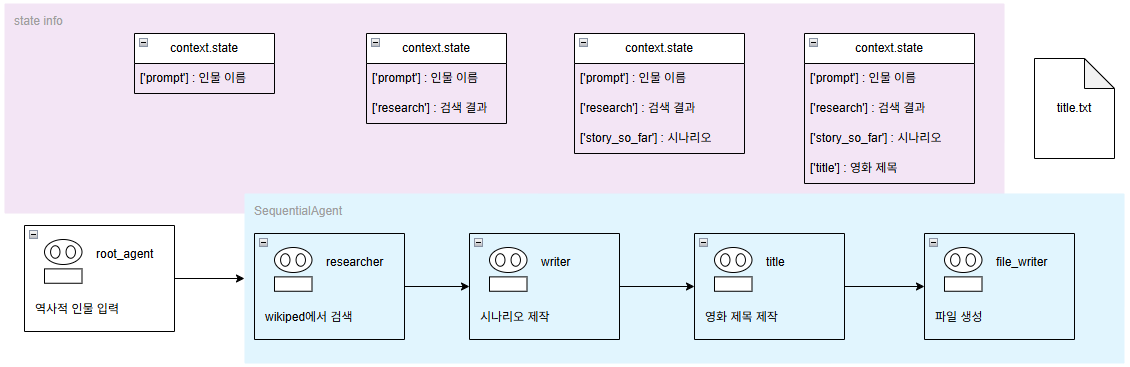

#### 1.2.1.2 시나리오 수정

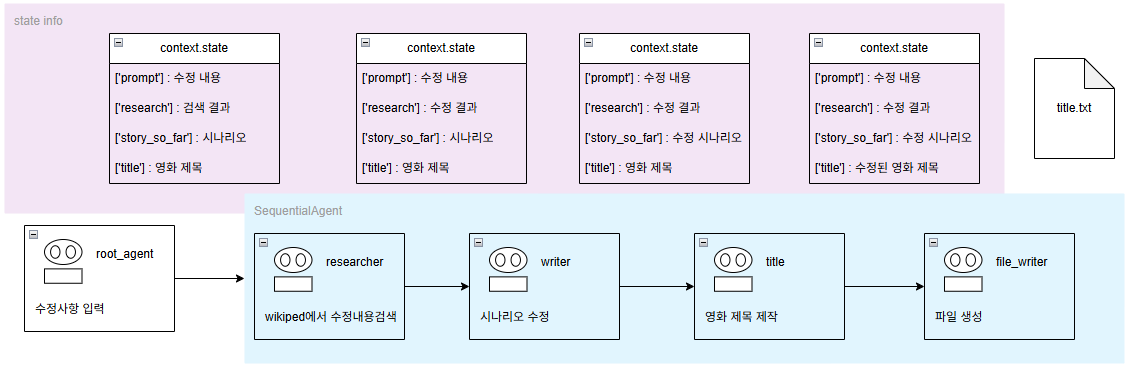

### 1.2.2 전체 흐름

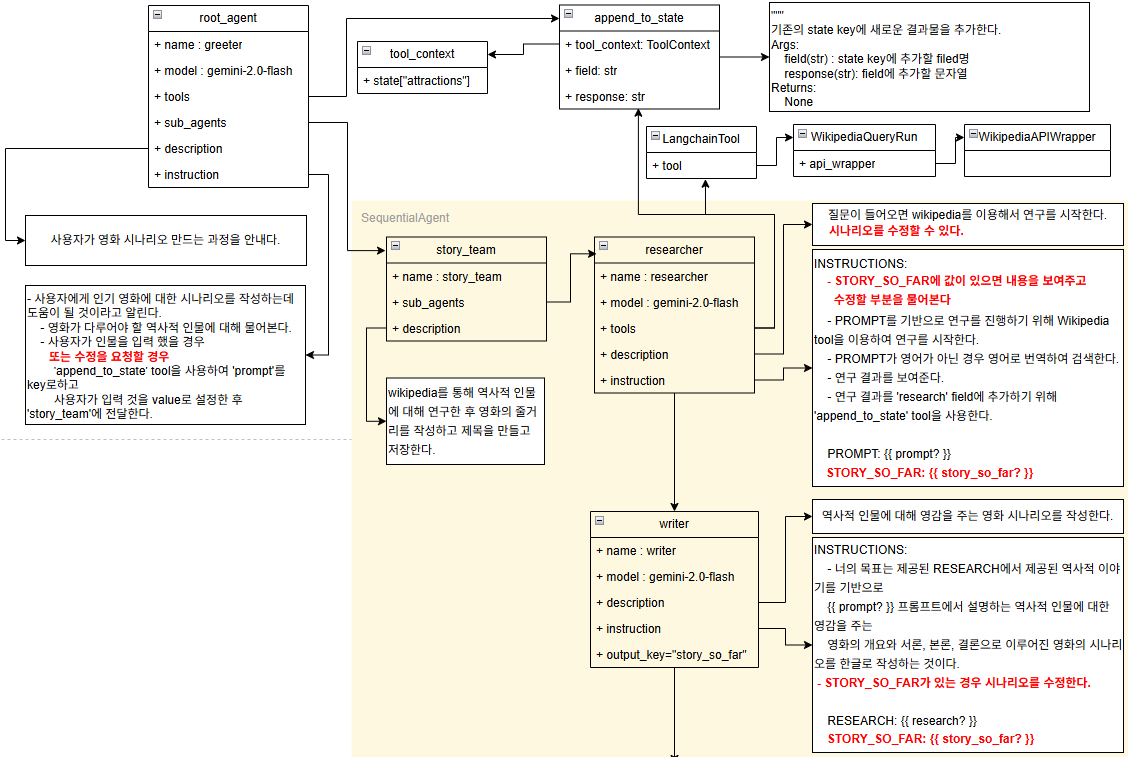

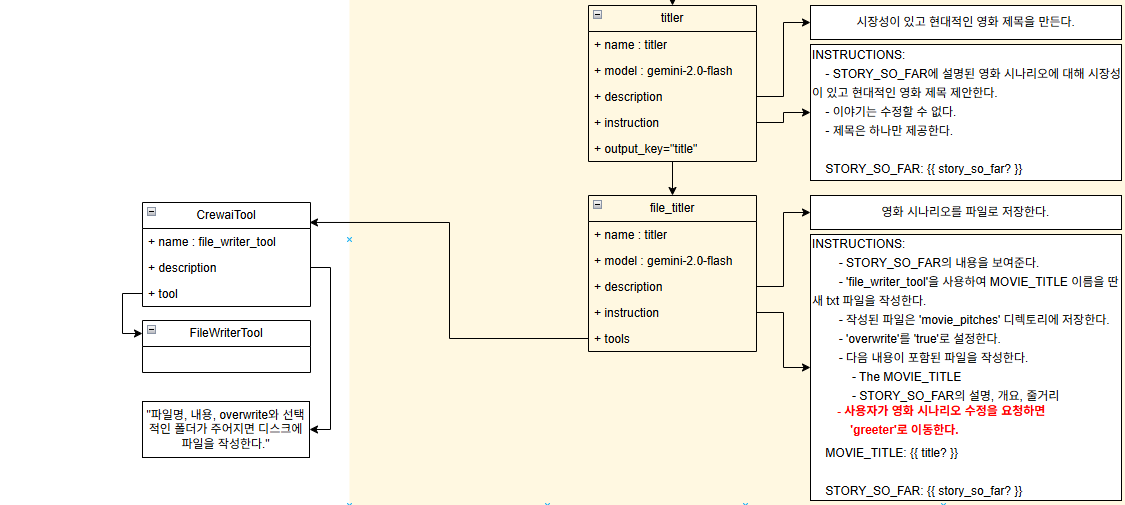

## 1.2.3 실행결과

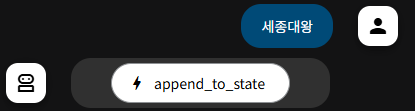

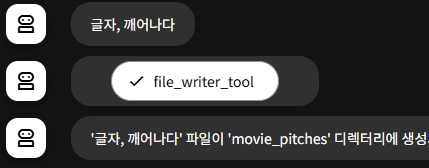

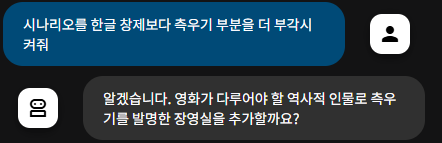

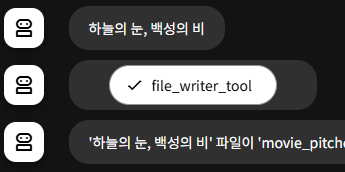

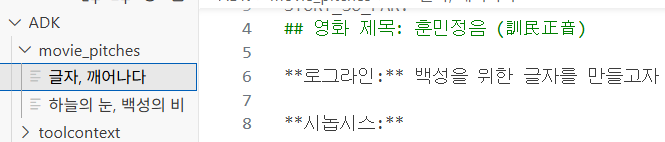

## 1.3 시나리오 자동 수정

### 1.3.1 Agent에 따른 state 변환

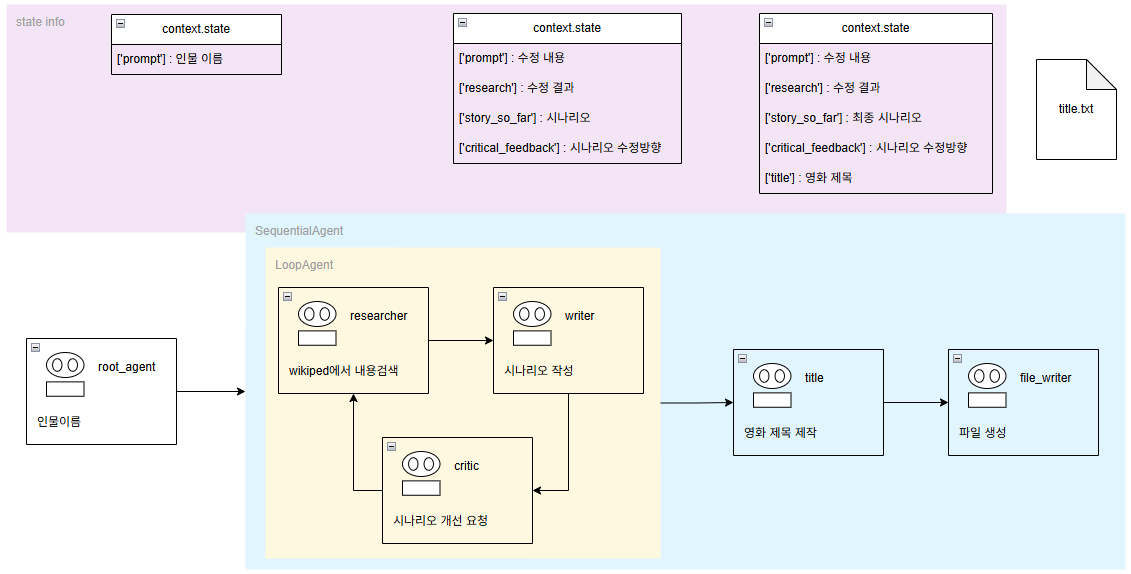

### 1.3.2 전체 흐름

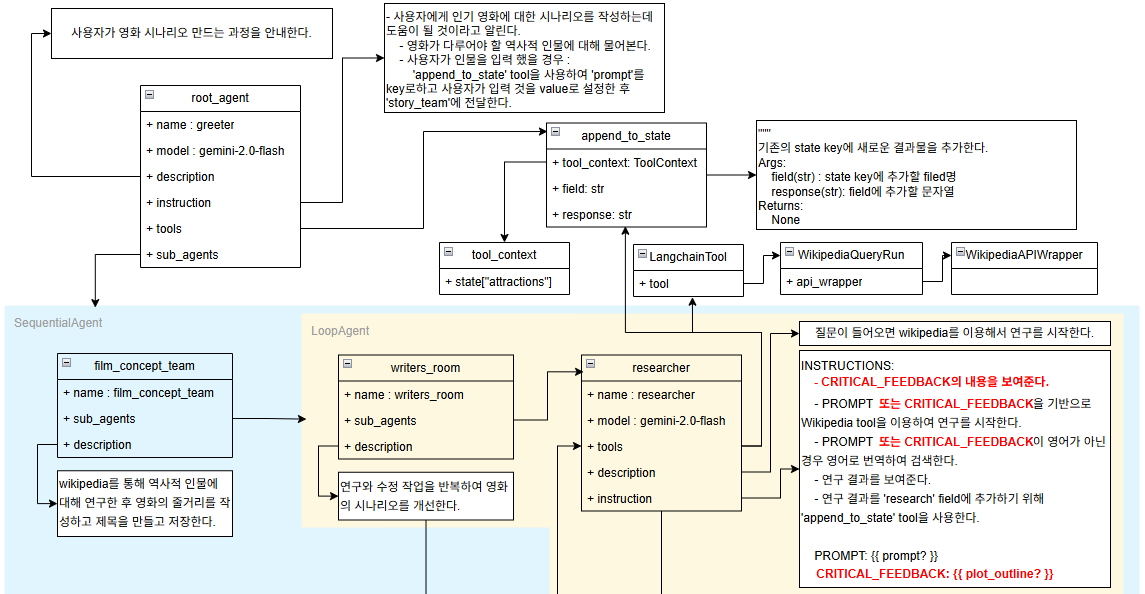

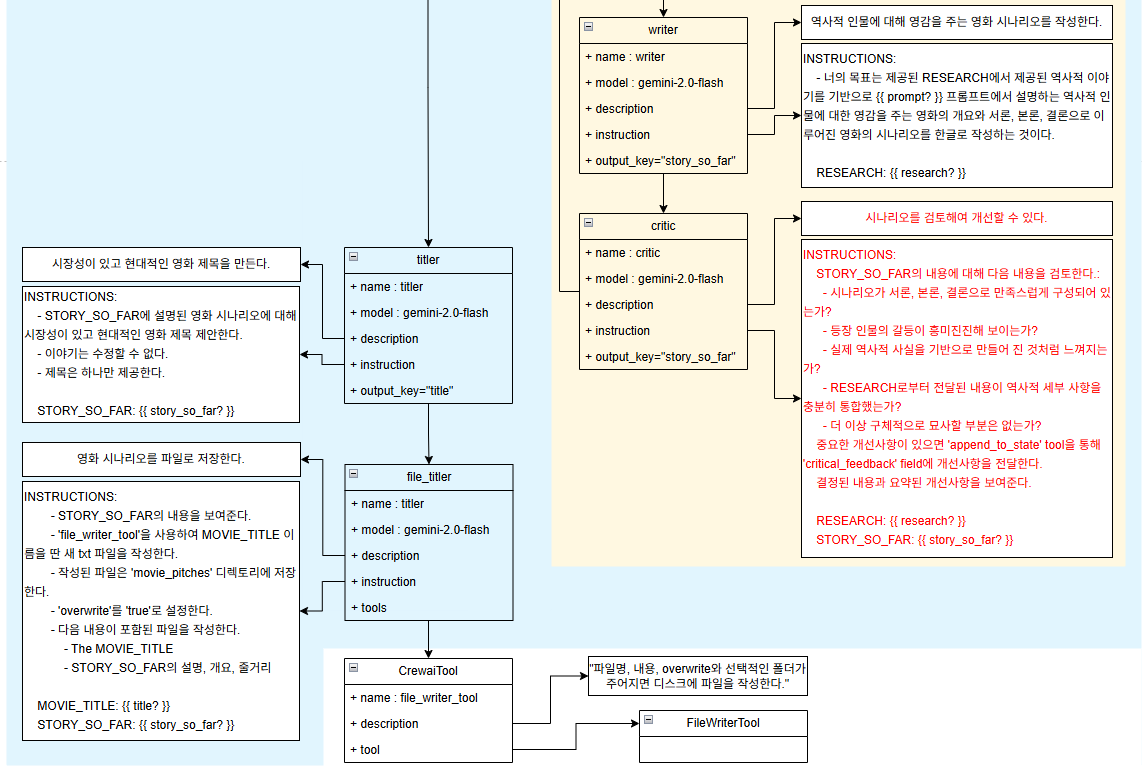

# 2. code



```
pip install google-adk
pip install langchain-community crewai-tools wikipedia
```





```
from google.adk import Agent
from google.adk.agents import SequentialAgent, LoopAgent
from google.adk.tools.tool_context import ToolContext
from google.adk.tools.langchain_tool import LangchainTool
from google.adk.tools.crewai_tool import CrewaiTool

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from crewai_tools import FileWriterTool
from google.adk.tools import exit_loop

model_name="gemini-2.0-flash"

def append_to_state(
    tool_context: ToolContext,
    field: str,
    response: str
) -> dict[str, str]:
    """
    기존의 state key에 새로운 결과물을 추가한다..
    Args:
        field (str): state에 추가할 key 이름
        response (str): field에 추가할 문자열
    
    Returns:
        dict[str, str]: {"status": "success"}
    """
    existing_state = tool_context.state.get(field, [])
    tool_context.state[field] = existing_state + [response]
    return {"status": "success"}
    
file_writer = Agent(
    name="file_writer",
    model=model_name,
    description="영화 시나리오를 파일로 저장한다.",
    instruction="""
    ## Instructions
    - STORY_SO_FAR의 내용을 보여준다.
    - 'file_writer_tool'을 사용하여 MOVIE_TITLE 이름을 딴 새 txt 파일을 작성한다.
    - 작성된 파일은 'movie_pitches' 디렉토리에 저장한다.
    - 'overwrite'를 'true'로 설정한다.
    - 다음 내용이 포함된 파일을 작성한다.
        - The MOVIE_TITLE
        - STORY_SO_FAR의 설명, 개요, 줄거리  

    MOVIE_TITLE: {{ title? }}

    STORY_SO_FAR: {{ story_so_far? }}
    """,
    tools = [CrewaiTool(
        name="file_writer_tool",
        description=("파일 이름, 콘텐츠, 디렉터리를 설정한 후 실행하면 디스크에 파일을 만든다."),
        tool=FileWriterTool()
    )]
)

titler = Agent(
    name="titler",
    model=model_name,
    description="시장성이 있고 현대적인 영화 제목을 만든다.",
    instruction="""
    INSTRUCTIONS:
    - STORY_SO_FAR에 설명된 영화 시나리오에 대해 시장성이 있고 현대적인 영화 제목 제안한다.
    - 이야기는 수정할 수 없다.
    - 제목은 하나만 제공한다.

    STORY_SO_FAR: {{ story_so_far? }}
    """,
    output_key="title",
    )

critic = Agent(
    name="critic",
    model=model_name,
    description="시나리오를 검토해여 개선할 수 있다.",
    instruction="""
    INSTRUCTIONS:
    STORY_SO_FAR의 내용에 대해 다음 내용을 검토한다.:
        - 시나리오가 서론, 본론, 결론으로 만족스럽게 구성되어 있는가?
        - 등장 인물의 갈등이 흥미진진해 보이는가?
        - 실제 역사적 사실을 기반으로 만들어 진 것처럼 느껴지는가?
        - RESEARCH로부터 전달된 내용이 역사적 세부 사항을 충분히 통합했는가?
        - 더 이상 구체적으로 묘사할 부분이 없는가?
    STORY_SO_FAR이 이러한 질문을 잘 처리했다면 'exit_loop' 도구를 사용하여 쓰기 루프를 종료한다.
    중요한 개선사항이 있으면 'append_to_state' tool을 통해 'critical_feedback' field에 개선사항을 전달한다.
    결정된 내용과 요약된 개선사항을 보여준다.
    

    RESEARCH: {{ research? }}

    STORY_SO_FAR: {{ story_so_far? }}
    """,
    tools=[append_to_state, exit_loop],
)
writer = Agent(
    name="writer",
    model=model_name,
    description="역사적 인물에 대해 영감을 주는 영화 시나리오를 작성한다.",
    instruction="""
    INSTRUCTIONS:
    - 너의 목표는 제공된 RESEARCH에서 제공된 역사적 이야기를 기반으로
    {{ prompt? }} 프롬프트에서 설명하는 역사적 인물에 대한 영감을 주는
    영화의 개요와 서론, 본론, 결론으로 이루어진 영화의 시나리오를 한글로 작성하는 것이다.

    RESEARCH: {{ research? }}
    """,
    output_key="story_so_far",
)
#  PLOT_OUTLINE: {{ PLOT_OUTLINE? }} 관련 내용 추가
researcher = Agent(
    name="researcher",
    model=model_name,
    description="질문이 들어오면 wikipedia를 이용해서 연구를 시작한다.",
    instruction="""
    INSTRUCTIONS:
    - CRITICAL_FEEDBACK의 내용을 보여준다.
    - PROMPT 또는 CRITICAL_FEEDBACK을 기반으로 연구를 진행하기 위해 Wikipedia tool을 이용하여 연구를 시작한다.
    - PROMPT 또는 CRITICAL_FEEDBACK이 영어가 아닌 경우 영어로 번역하여 검색한다.
    - 연구 결과를 보여준다.
    - 연구 결과를 'research' field에 추가하기 위해 'append_to_state' tool을 사용한다.

    PROMPT: {{ prompt? }}

    CRITICAL_FEEDBACK: {{ critical_feedback? }}
    """,
    tools = [
        LangchainTool(
            tool=WikipediaQueryRun(
                api_wrapper=WikipediaAPIWrapper()
            )
        ),
        append_to_state
    ]
)

writers_room = LoopAgent(
    name="writers_room",
    description="연구와 수정 작업을 반복하여 영화의 시나리오를 개선한다.",
    sub_agents=[
        researcher,
        writer,
        titler,
        file_writer,
        critic
    ],
    max_iterations=5,
)

film_concept_team = SequentialAgent(
    name="film_concept_team",
    description="영화의 시나리오를 작성하여 텍스트 파일로 저장한다.",
    sub_agents=[
        writers_room,
        # titler,
        # file_writer
    ],
)

root_agent = Agent(
    name="greeter",
    model=model_name,
    description="사용자가 영화 시나리오 만드는 과정을 안내한다.",
    instruction="""
    - 사용자에게 인기 영화에 대한 시나리오를 작성하는데 도움이 될 것이라고 알린다.
    - 영화가 다루어야 할 역사적 인물에 대해 물어본다.
    - 사용자가 인물을 입력 했을 경우:
        'append_to_state' tool을 사용하여 'prompt'를 key로하고
        사용자가 입력 것을 value로 설정한 후 'film_concept_team'에 전달한다.
    """,
    tools=[append_to_state],
    sub_agents=[film_concept_team]
)
```

